# Dask Delayed

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask Delayed"
* https://docs.dask.org/en/latest/delayed.html
* Jesse C. Daniel. Data Science with Python and Dask.
* https://saturncloud.io/blog/a-data-scientist-s-guide-to-lazy-evaluation-with-dask/
* https://www.coiled.io/blog/how-to-learn-dask-in-2021
* https://realpython.com/python-concurrency/

## Задачи для совместного разбора

1\. Напишите 2 функции, имитирующие CPU-bound задачу и IO-bound задачу:

`cpu_task()`: генерирует 100 тыс. случайных чисел и возвращает их сумму (без использования `numpy`)

`io_task()`: "спит" 0.1 сек, затем генерирует случайное число и возвращает его

Замерьте время выполнения 100 последовательных вызовов каждой из этих функций. Распараллелив вычисления при помощи `dask.delayed`, сократите время выполнения. Исследуйте, как зависит время вычислений от выбранного планировщика `scheduler`.

In [1]:
import numpy as np
import dask.delayed as delayed
import dask
from time import sleep
import random

In [5]:
def cpu_task():
    number = [random.randint(0, 100) for _ in range(100_100)]
    s = sum(number)
    return s

In [6]:
def io_task():
    sleep(0.1)
    return random.randint(0, 100)

In [7]:
%%time
r = [cpu_task() for _ in range(100)]

CPU times: total: 17.7 s
Wall time: 23.9 s


In [8]:
%%time
r = [io_task() for _ in range(100)]

CPU times: total: 0 ns
Wall time: 11 s


In [18]:
cpu_task_delayed = delayed(cpu_task)

In [13]:
d = cpu_task_daleyed()
d2 = (d - 5_000_000)
#d.compute()
d2.compute()

628

In [15]:
!pip install --user graphviz

In [25]:
import os
graphviz_path = "C:/Users/cosit/Downloads/Graphviz/bin"
os.environ["PATH"] += (os.pathsep + graphviz_path)    

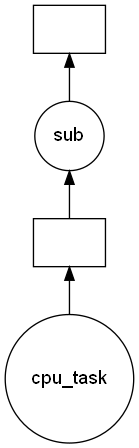

In [26]:
d2.visualize()

In [22]:
%%time
r = [cpu_task_delayed() for _ in range(100)]
r_c = dask.compute(r, scheduler="processes")

CPU times: total: 46.9 ms
Wall time: 2.88 s


In [20]:
@delayed
def io_task_delayed():
    sleep(0.1)
    return random.randint(0, 100)

In [21]:
%%time
r = [io_task_delayed() for _ in range(100)]
r_c = dask.compute(r)

CPU times: total: 0 ns
Wall time: 1.44 s


## Лабораторная работа 14

In [2]:
import dask.delayed as delayed
import dask

<p class="task" id="1"></p>

1\. Напишите функцию `read_profiles`, которая считывает один файл формата xml из каталога `reviewers_full` и по данным этого файла формирует список словарей, содержащих следующие ключи: `id`, `username`, `name`, `sex`, `country`, `mail`, `registered`, `birthdate`, `name_prefix`, `country_code`. Часть из этих значений в исходном файле хранится в виде тэгов, часть - в виде атрибутов тэгов. Для конкретного человека какие-то из этих ключей могут отсутствовать. 

Обработайте все файлы, вызвав последовательно вызвав эту функцию для каждого из них, и собрав результаты в один общий список словарей `profiles`. Измерьте время выполнения кода.

Выведите на экран уникальные значения по ключам `name_prefix` и `country_code`


```python
def read_profiles(file: str) -> list[dict]:
    pass
```

In [2]:
from bs4 import BeautifulSoup

In [104]:
def read_profiles(file: str):
    with open(f'reviewers_full/{file}', 'r') as f:
        soup = BeautifulSoup(f, 'lxml')
        f.close()
    res = []
    for user in soup.find_all('user'):
        try:
            pr = user['prefix']
            user_info = list(map(lambda x: (x.name, x.text), user.findChildren())) + [('name_prefix', pr)]
        except KeyError:
            user_info = list(map(lambda x: (x.name, x.text), user.findChildren()))
        if user.find('country'):
            try:
                user_info.append(('country_code', user.find('country')['code']))
            except KeyError:
                pass
        res.append(dict(user_info))
    return res

In [108]:
import os
from tqdm import tqdm
files = os.listdir('reviewers_full')
profiles = []
for f in tqdm(files, total=len(files)):
    profiles.extend(read_profiles(f))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\cosit\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:41<00:00, 23.09s/it]


<p class="task" id="2"></p>

2\. Задекорируйте функцию `read_profiles` при помощи `dask.delayed`. Cоздайте список `reviewers`, состоящий из 20 объектов `Delayed` (по одному объекту на файл). Повторите решение задачи 1, распараллелив вычисления при помощи `dask`. Измерьте время выполнения кода. Добейтесь существенного (в разы) уменьшения времени выполнения в сравнении с решением задачи 1.

In [110]:
read_profiles_delayed = delayed(read_profiles)

In [111]:
%%time
reviewers = [read_profiles_delayed(file) for file in files]
reviewers_c = dask.compute(reviewers, scheduler="processes")

CPU times: total: 2.17 s
Wall time: 2min 37s


<p class="task" id="3"></p>

3\. Задекорируйте функцию из задания 1 при помощи `dask.delayed` и создайте список `reviewers`, состоящий из 20 объектов `Delayed` (по одному объекту на файл). Из списка объектов `Delayed`, создайте `dask.bag` при помощи метода `db.from_delayed`. Добавьте ключ `birth_year`, в котором хранится год рождения человека. Оставьте в выборке только тех людей, которые __наверняка__ моложе 1980 года. Преобразуйте поле `id` к целому типу.

Выведите на экран количество элементов в созданном `Bag`.

In [115]:
import dask.bag as db

In [112]:
read_profiles_delayed = delayed(read_profiles)
reviewers = [read_profiles_delayed(file) for file in files]

In [116]:
bag = db.from_delayed(reviewers).persist()

In [133]:
def add_birthyear(dic):
    try:
        dic['birth_year'] = dic['birthdate'].split('-')[0]
    except KeyError:
        pass
    return dic
def filter_young(dic):
    try:
        if dic['birth_year'] >= '1980':
            return True
        else:
            return False
    except KeyError:
        return False
def int_id(dic):
    dic['id'] = int(dic.get('id'))
    return dic
young_people = bag.map(add_birthyear).filter(filter_young).map(int_id)
young_people.take(1)

({'birthdate': '2005-03-06',
  'country': 'Germany',
  'id': 68591,
  'sex': 'F',
  'username': 'daniellegomez',
  'name_prefix': 'Dr.',
  'country_code': 'DE',
  'birth_year': '2005'},)

In [135]:
young_people.count().compute()

294364

<p class="task" id="4"></p>

4\. Преобразуйте `Bag` из предыдущего задания в `dd.DataFrame`. Найдите и выведите на экран страну с наибольшим количеством пользователей.

In [ ]:
import dask.dataframe as dd

In [137]:
df = young_people.to_dataframe()
df.head()

,birthdate,country,id,sex,username,name_prefix,country_code,birth_year
0,2005-03-06,Germany,68591,F,daniellegomez,Dr.,DE,2005
1,1994-10-10,Aruba,43614,F,jeffreynelson,NaN,AW,1994
2,1996-09-07,NaN,25362,NaN,davidmaxwell,NaN,NaN,1996
3,1997-03-29,Tajikistan,1509,F,thomas07,Dr.,TJ,1997
4,1990-04-22,NaN,94076,NaN,hannahturner,NaN,NaN,1990


In [147]:
ind = df.groupby('country', observed=True)['id'].count().max()
countries = df.groupby('country', observed=True)['id'].count()
countries[countries==ind].compute()

country
Korea    1212
Name: id, dtype: int64

<p class="task" id="5"></p>

5\. Даны две функции: `get_product` и `add_to_db`. Воспользовавшись функцией `get_product`, получите список из 16 товаров с ID от 1 до 16. Добавьте каждый товар в БД __по отдельности__ при помощи функции `add_to_db`. Посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

При решении данной задачи не используйте параллельных вычислений (включая `dask`). 

__Важно__: выполните ячейку ниже и далее работайте с запущенным `Client` (даже если вы его не используете, как в этой задаче).

In [3]:
# ЭТА ЯЧЕЙКА ЯВЛЯЕТСЯ ЧАСТЬЮ УСЛОВИЯ ЗАДАЧИ
# ИЗМЕНЯТЬ СОДЕРЖИМОЕ ЭТОЙ ЯЧЕЙКИ ЗАПРЕЩЕНО

import requests
from dask.distributed import Semaphore, Client
import time

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62554,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:62579,Total threads: 2
Dashboard: http://127.0.0.1:62581/status,Memory: 3.92 GiB
Nanny: tcp://127.0.0.1:62557,


In [4]:
# ЭТА ЯЧЕЙКА ЯВЛЯЕТСЯ ЧАСТЬЮ УСЛОВИЯ ЗАДАЧИ
# ИЗМЕНЯТЬ СОДЕРЖИМОЕ ЭТОЙ ЯЧЕЙКИ ЗАПРЕЩЕНО

def get_product(pid: int) -> dict:
    """Делает запрос к dummyjson и возвращает информацию о товаре"""
    return requests.get(f"https://dummyjson.com/products/{pid}").json()

def estimate_fake_delay_time(n: int) -> float:
    """Возвращает кол-во секунд для задержки в зависимости от числа n"""
    return 0.07*n**2 -0.03*n + 2

sem = Semaphore(2)

def add_to_db(*products):
    """Принимает на вход переменное количество словарей (товаров), считает сумму и имитирует
    длительную операцию сохранения этих элементов в БД, время выполнения которой зависит от кол-ва переданных элементо. 
    Одновременно могут обрабатываться только 2 запроса (это контролируется семафором)."""
    ttl = 0
    for p in products:
        print("Added {} to db".format(p["title"]))
        ttl += p["price"]
    with sem:    
        time.sleep(estimate_fake_delay_time(len(products)))
    return ttl

In [153]:
%%time
products = [get_product(i) for i in range(1, 17)]
titles = [add_to_db(prod) for prod in products]
sum(titles)

Added iPhone 9 to db
Added iPhone X to db
Added Samsung Universe 9 to db
Added OPPOF19 to db
Added Huawei P30 to db
Added MacBook Pro to db
Added Samsung Galaxy Book to db
Added Microsoft Surface Laptop 4 to db
Added Infinix INBOOK to db
Added HP Pavilion 15-DK1056WM to db
Added perfume Oil to db
Added Brown Perfume to db
Added Fog Scent Xpressio Perfume to db
Added Non-Alcoholic Concentrated Perfume Oil to db
Added Eau De Perfume Spray to db
Added Hyaluronic Acid Serum to db
CPU times: total: 1.66 s
Wall time: 46.8 s


10656

<p class="task" id="6"></p>

6\. Создайте отложенные версии функций `get_product` и `add_to_db`. Постройте при помощи этих функций граф вычислений, который будет выглядеть следующим образом:

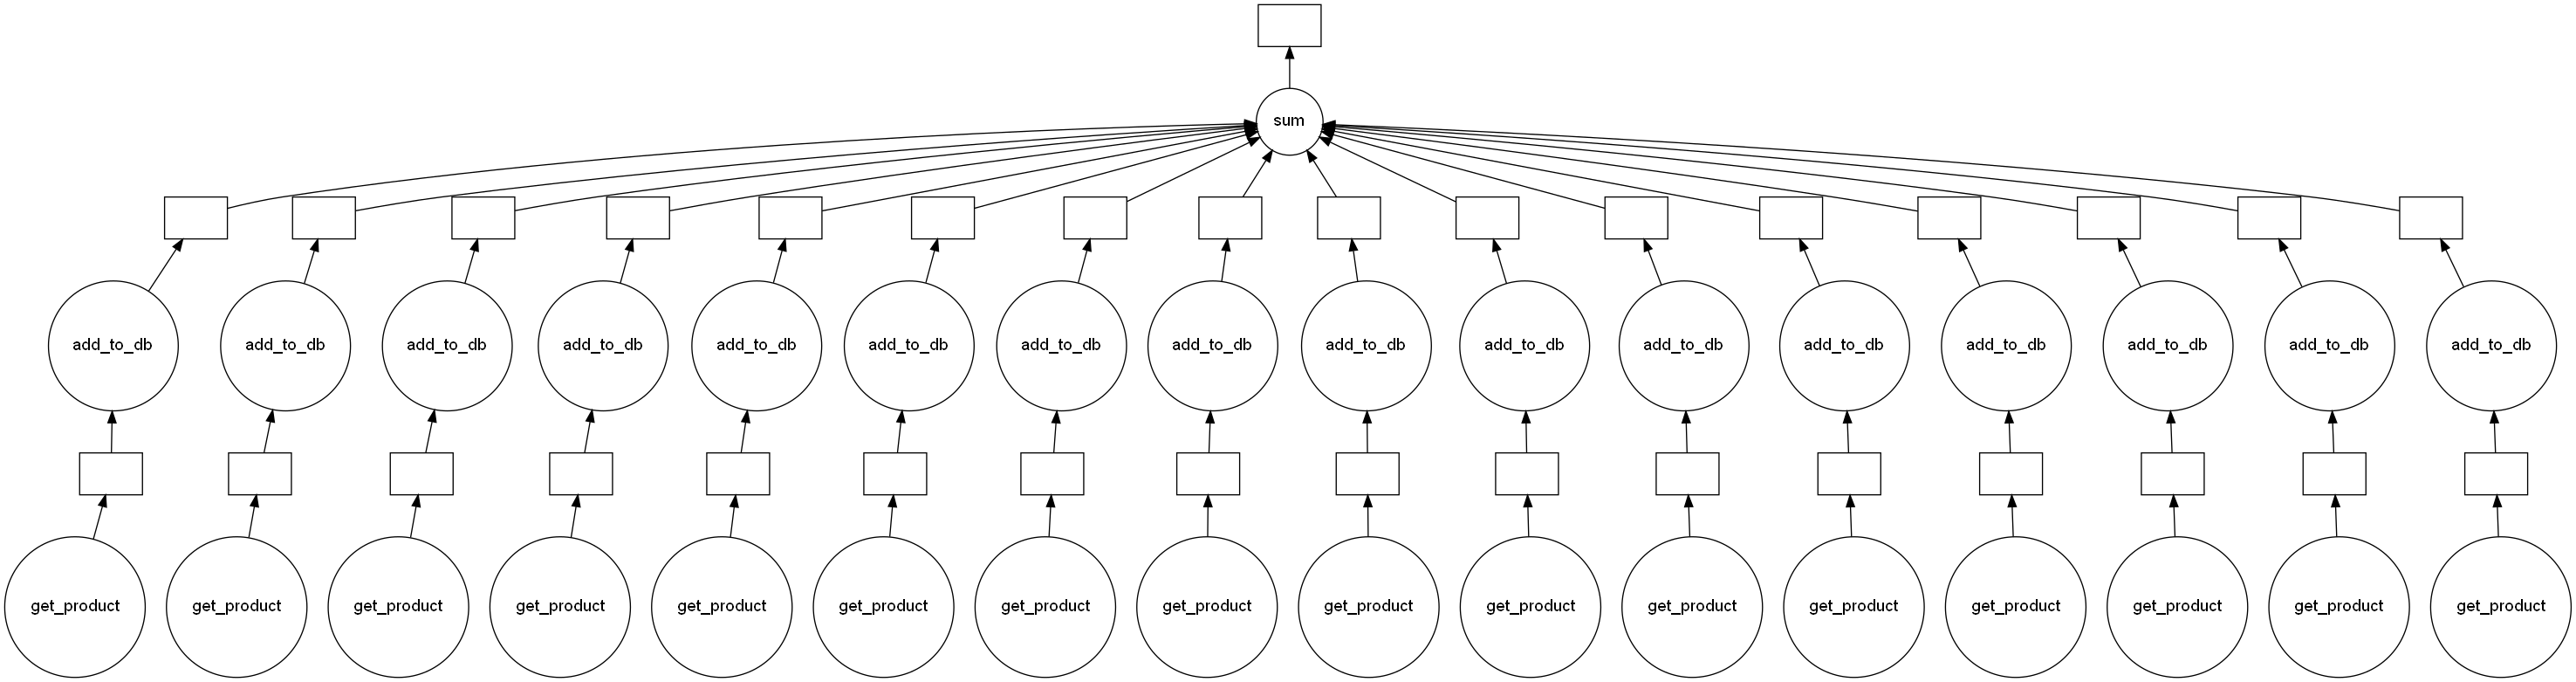

Здесь для каждого товара параллельно происходит вызов `get_product`, за которым следует вызов  `add_to_db`. Используя построенный граф, посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

В качестве демонстрации вставьте скриншот графа в процессе вычислений из дэшборда или результат работы метода `visualize`.

In [6]:
get_product_dl = delayed(get_product)
add_to_db_dl = delayed(add_to_db)
sum_dl = delayed(sum)

In [159]:
%%time
products = [get_product_dl(i) for i in range(1, 17)]
titles = [add_to_db_dl(prod) for prod in products]
res = sum_dl(titles)
ans = dask.compute(res)
ans

CPU times: total: 1.16 s
Wall time: 19.1 s


(10656,)

In [10]:
import os
graphviz_path = "C:/Users/cosit/Downloads/Graphviz/bin"
os.environ["PATH"] += (os.pathsep + graphviz_path)  

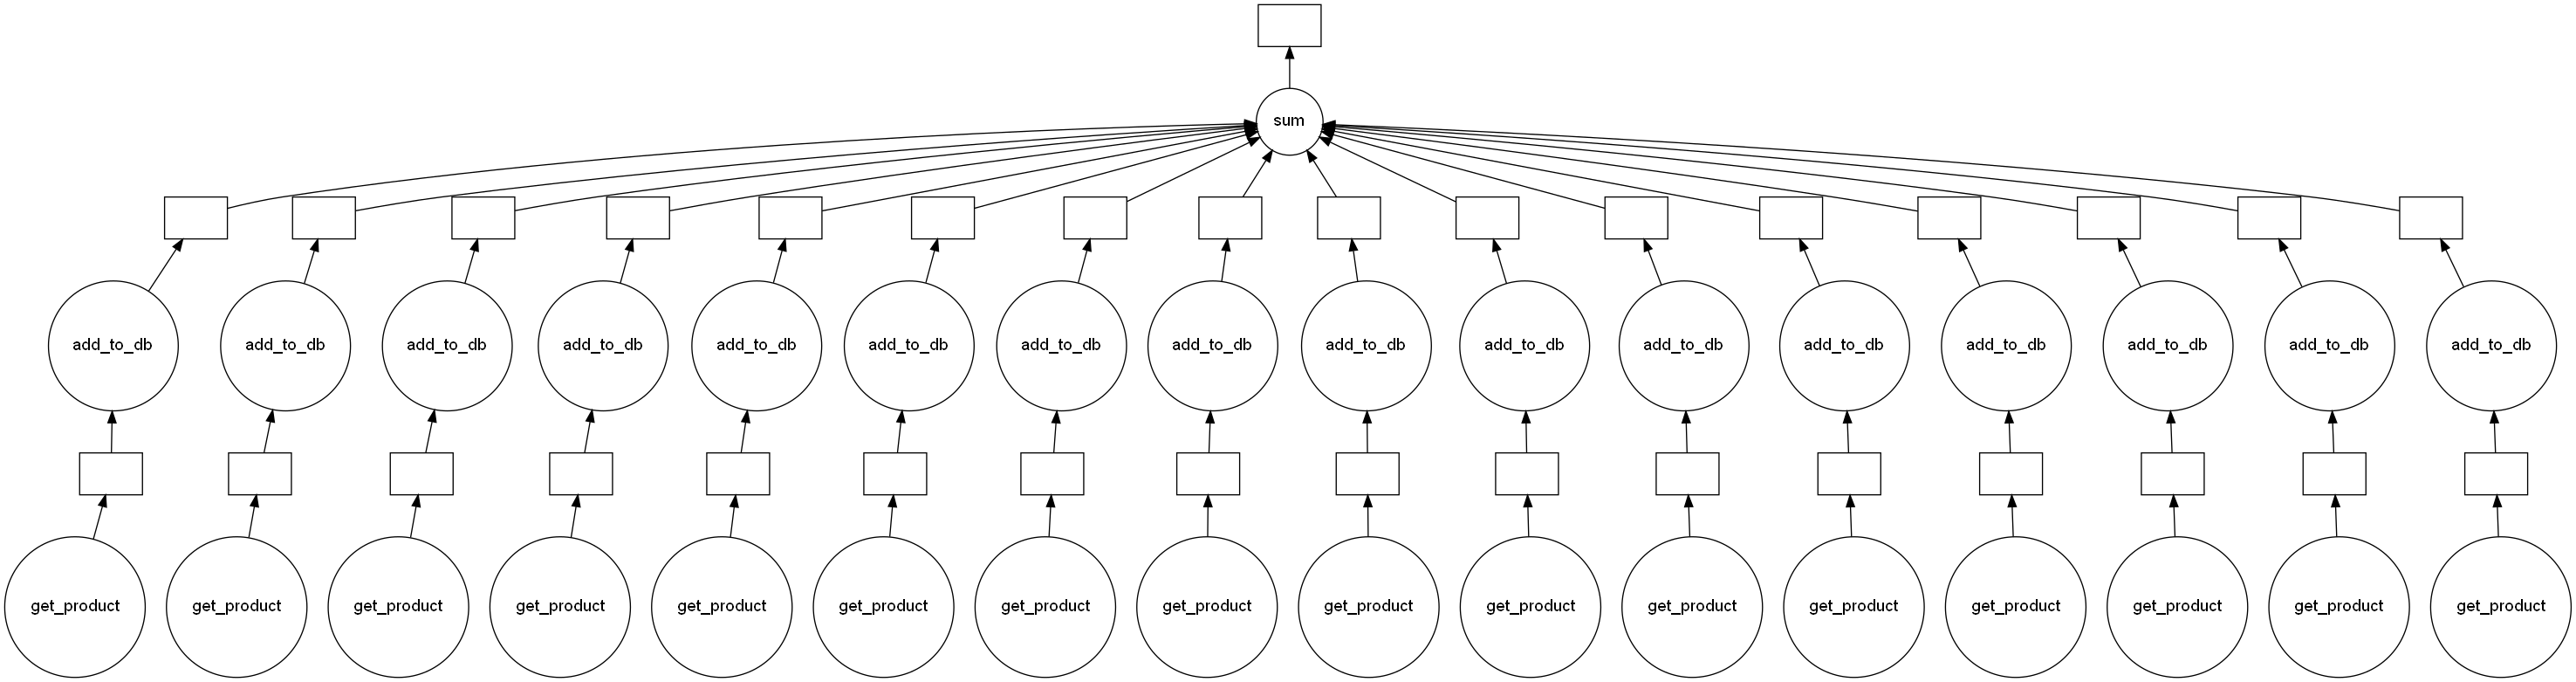

In [162]:
res.visualize()

<p class="task" id="7"></p>

7\. Перестройте граф вычислений таким образом, чтобы на вход `add_to_db` передавалось сразу по 4 товара. Граф вычислений должен иметь следующий вид:

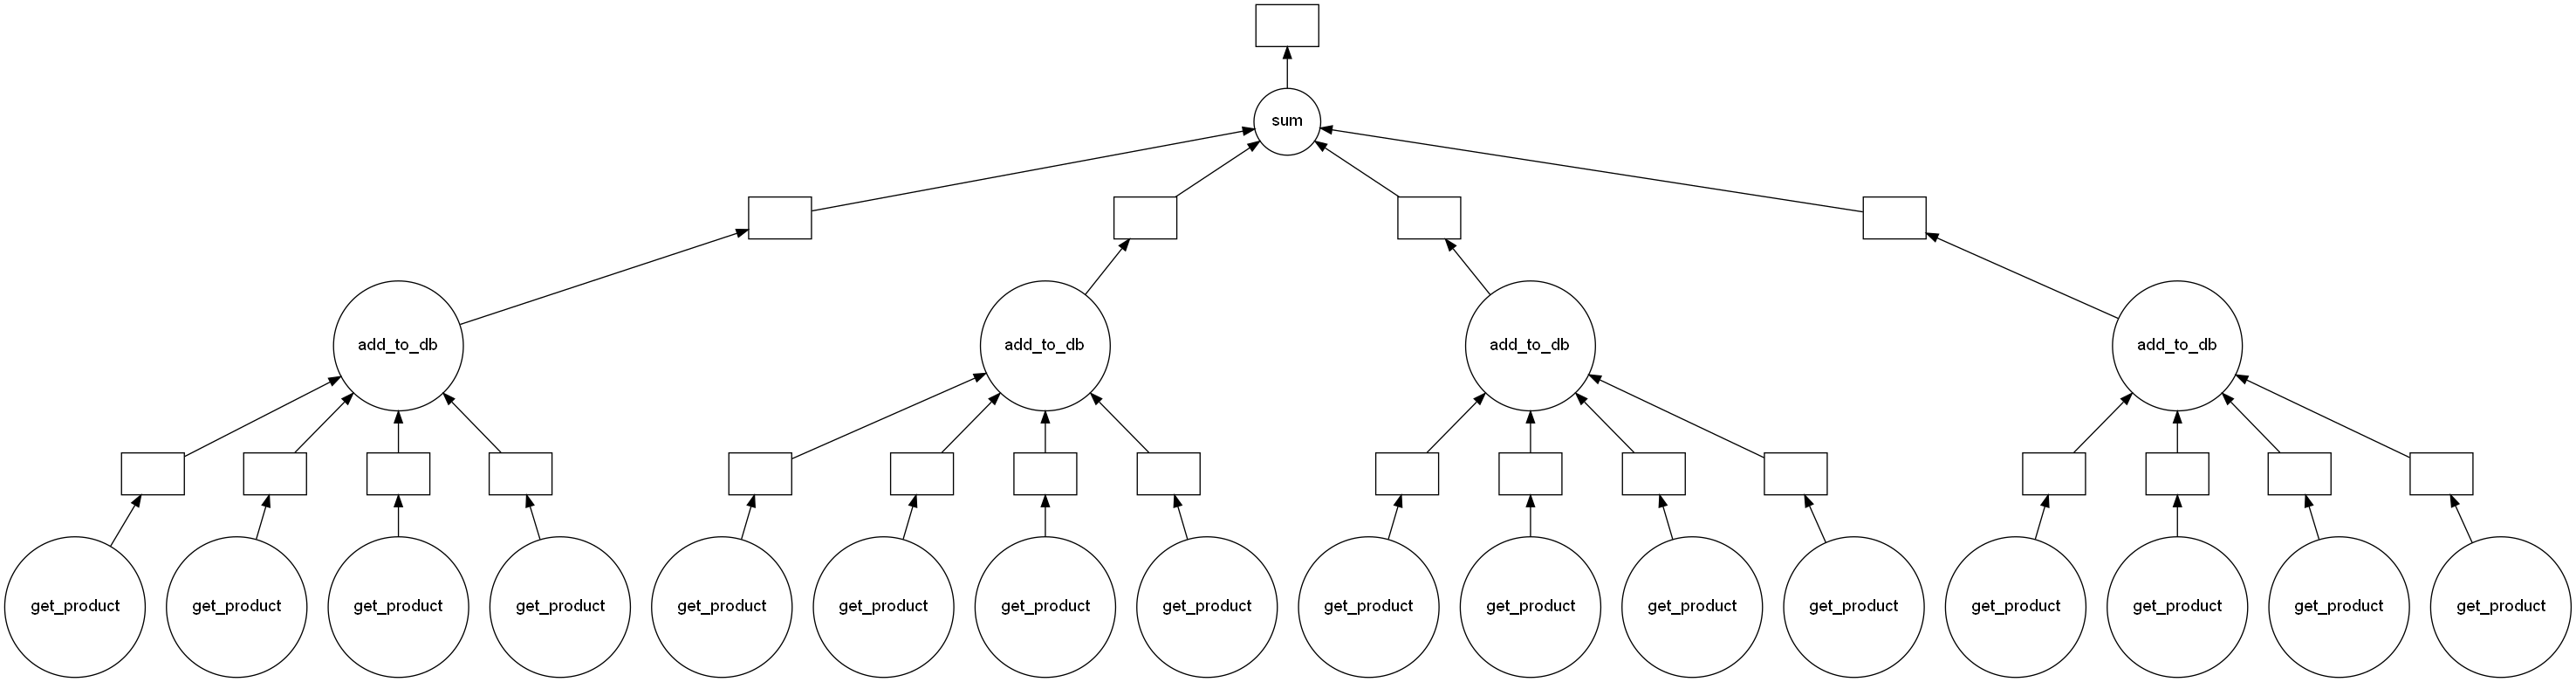

Используя построенный граф, посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

В качестве демонстрации вставьте скриншот графа в процессе вычислений из дэшборда или результат работы метода `visualize`.

In [8]:
%%time
products = [get_product_dl(i) for i in range(1, 17)]
res = sum_dl([add_to_db_dl(*products[i - 4:i]) for i in range(4, 17, 4)])
res.compute()

CPU times: total: 734 ms
Wall time: 10.3 s


10656

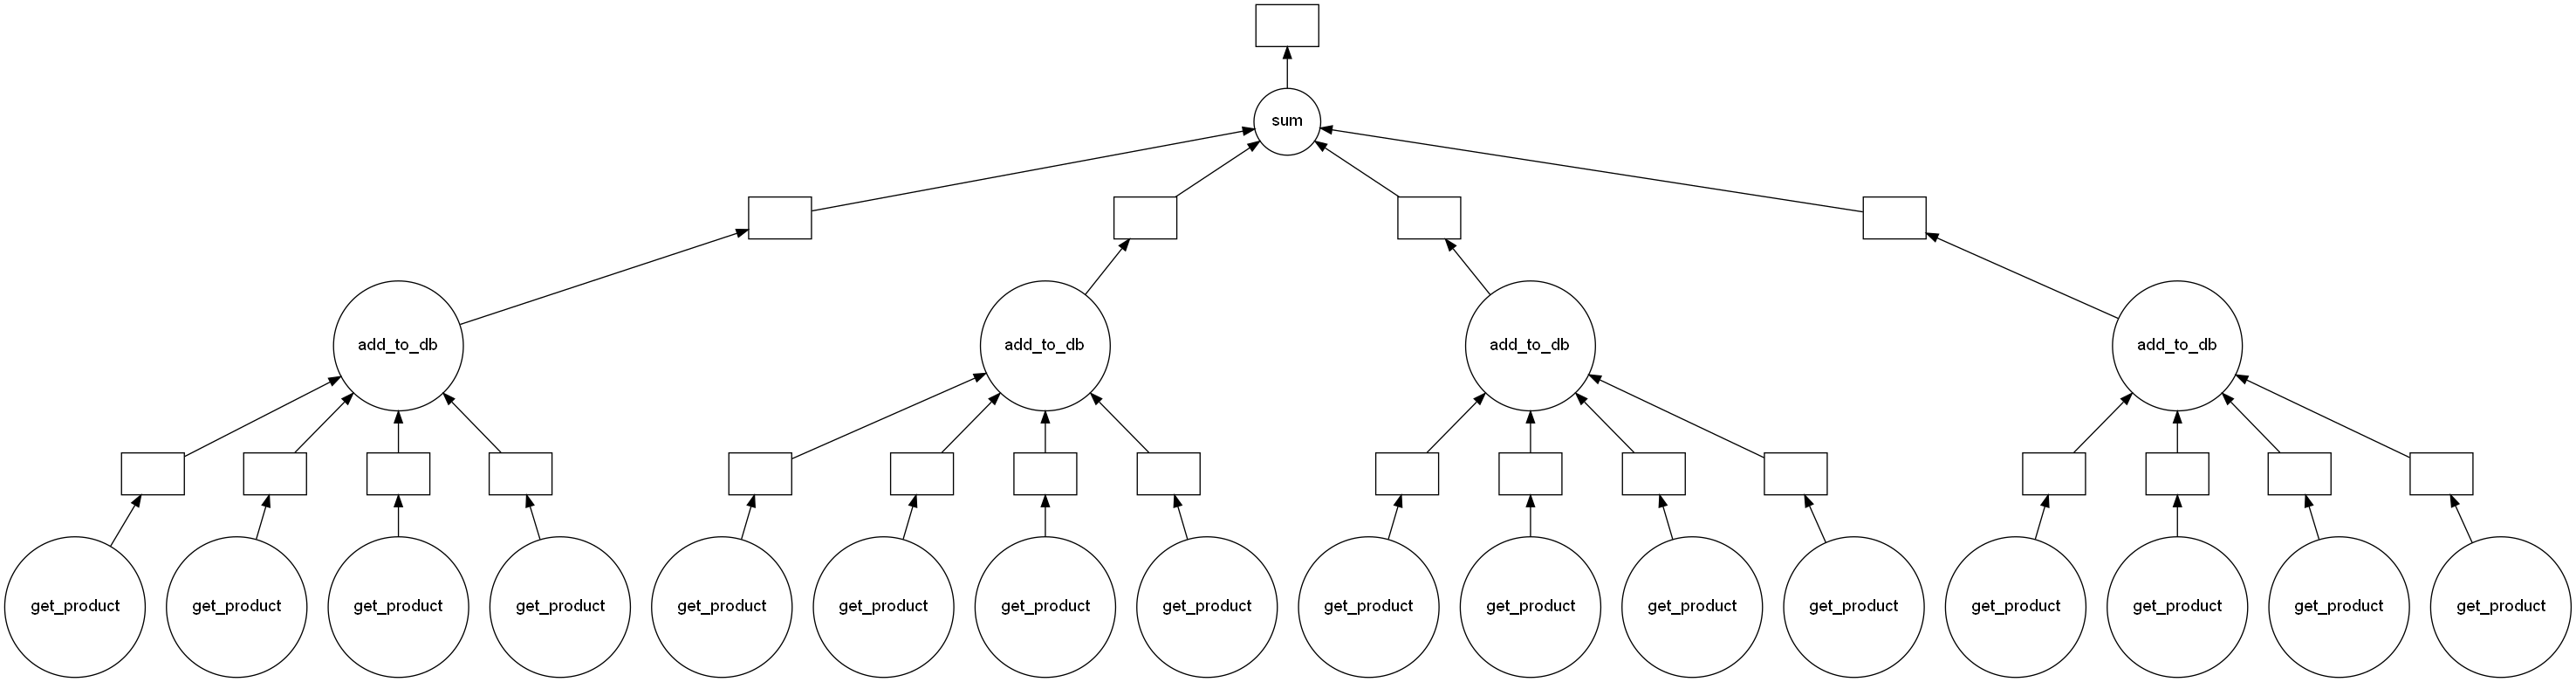

In [11]:
res.visualize()